# Time series exploratory data analysis

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/Colab_Notebooks/BDA')



# Types of trend and seasonality

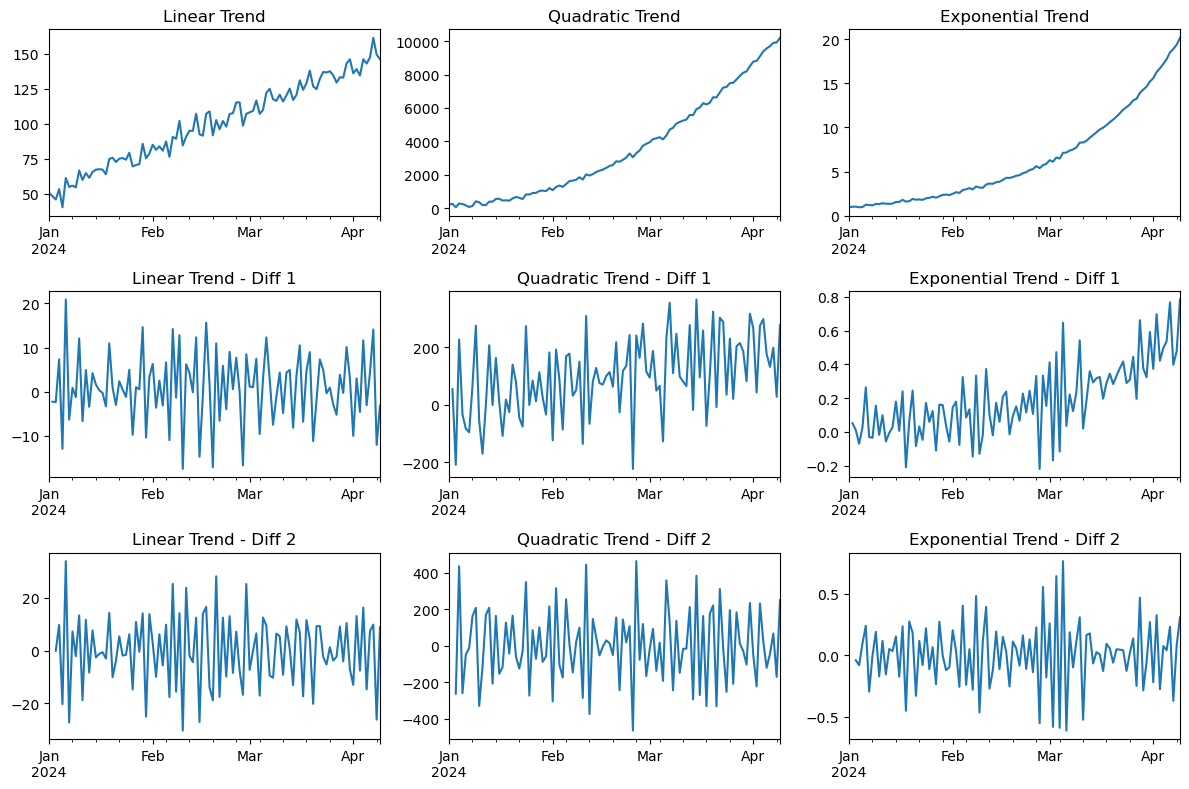

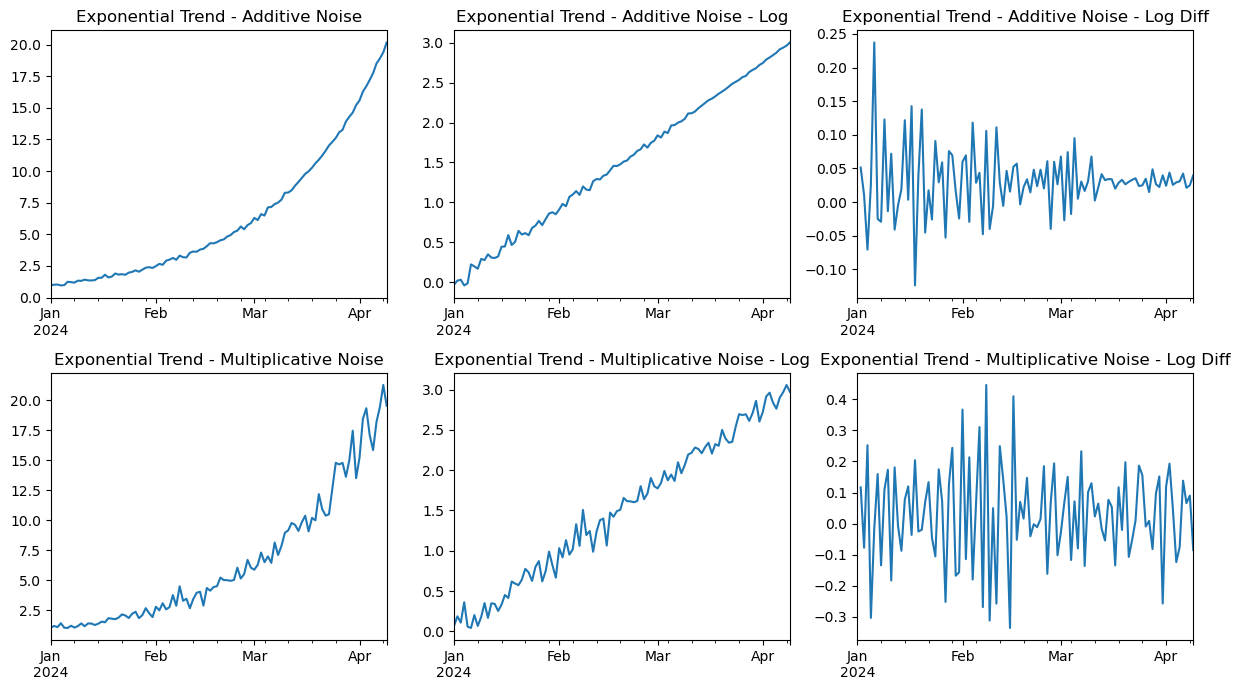

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Generate time series data
n = 100
index = pd.date_range(start='2024-01-01', periods=n, freq='D')

# Linear trend with noise
linear_trend = pd.Series(index=index, data=np.linspace(50, 150, n) + np.random.normal(0, 5, n))

# Quadratic trend with noise
quadratic_trend = pd.Series(index=index, data=(np.linspace(0, 100, n)**2 + np.random.normal(0, 100, n)) + 200)

# Exponential trend with noise additive
exponential_trend = pd.Series(index=index, data=np.exp(3*np.linspace(0, 1, n)) + np.random.normal(0, 0.1, n))

# Exponential trend with noise multiplicative
exponential_trend_mul = pd.Series(index=index, data=np.exp(3* np.linspace(0, 1, n)) * np.random.normal(1, 0.1, n))


# Plot original time series
plt.figure(figsize=(12, 8))
plt.subplot(3, 3, 1)
linear_trend.plot(title='Linear Trend')
plt.subplot(3, 3, 2)
quadratic_trend.plot(title='Quadratic Trend')
plt.subplot(3, 3, 3)
exponential_trend.plot(title='Exponential Trend')

# Apply first difference
plt.subplot(3, 3, 4)
linear_trend.diff().plot(title='Linear Trend - Diff 1')
plt.subplot(3, 3, 5)
quadratic_trend.diff().plot(title='Quadratic Trend - Diff 1')
plt.subplot(3, 3, 6)
exponential_trend.diff().plot(title='Exponential Trend - Diff 1')

# Apply second difference
plt.subplot(3, 3, 7)
linear_trend.diff().diff().plot(title='Linear Trend - Diff 2')
plt.subplot(3, 3, 8)
quadratic_trend.diff().diff().plot(title='Quadratic Trend - Diff 2')
plt.subplot(3, 3, 9)
exponential_trend.diff().diff().plot(title='Exponential Trend - Diff 2')
plt.tight_layout()
plt.show()

# Plot original time series
plt.figure(figsize=(12, 7))
plt.subplot(2, 3, 1)
exponential_trend.plot(title='Exponential Trend - Additive Noise')
plt.subplot(2, 3, 2)
np.log(exponential_trend).plot(title='Exponential Trend - Additive Noise - Log')
plt.subplot(2, 3, 3)
np.log(exponential_trend).diff().plot(title='Exponential Trend - Additive Noise - Log Diff')
plt.subplot(2, 3, 4)
exponential_trend_mul.plot(title='Exponential Trend - Multiplicative Noise')
plt.subplot(2, 3, 5)
np.log(exponential_trend_mul).plot(title='Exponential Trend - Multiplicative Noise - Log')
plt.subplot(2, 3, 6)
np.log(exponential_trend_mul).diff().plot(title='Exponential Trend - Multiplicative Noise - Log Diff')

plt.tight_layout()
plt.show()

## linear model: removing season and trend

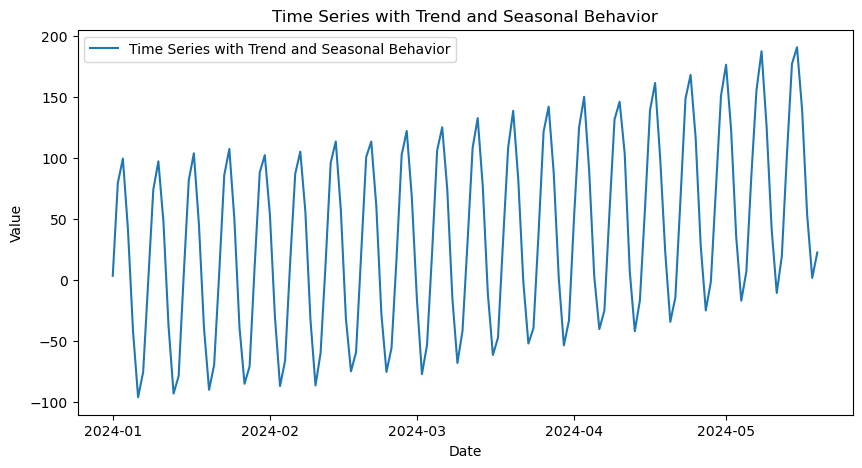

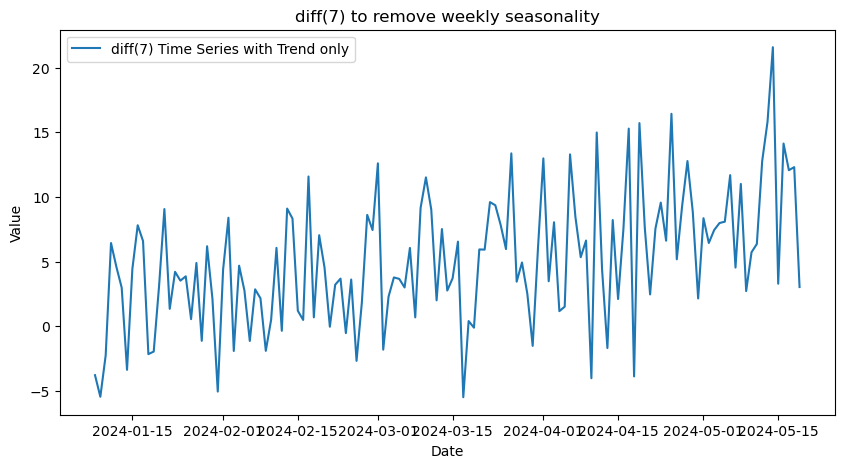

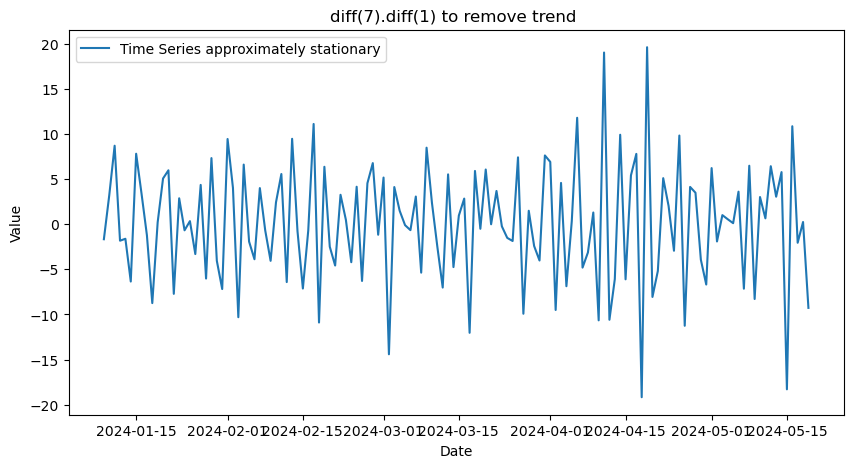

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Generate time series data with trend and seasonal behavior
n = 140
index = pd.date_range(start='2024-01-01', periods=n, freq='D')
linear_trend = np.linspace(1, 10, n)
seasonal_component = 100 * np.sin(2 * np.pi * np.arange(n) / 7)  # Weakly seasonality
noise_component = np.random.normal(0, 3, n) #additive noise
time_series = pd.Series(index=index, data=linear_trend**2 + seasonal_component + noise_component)

# Plot original time series
plt.figure(figsize=(10, 5))
plt.plot(time_series, label='Time Series with Trend and Seasonal Behavior')
plt.title('Time Series with Trend and Seasonal Behavior')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

# Plot original time series
plt.figure(figsize=(10, 5))
plt.plot(time_series.diff(7), label='diff(7) Time Series with Trend only')
plt.title('diff(7) to remove weekly seasonality')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

# Plot original time series
plt.figure(figsize=(10, 5))
plt.plot(time_series.diff(7).diff(), label='Time Series approximately stationary')
plt.title('diff(7).diff(1) to remove trend ')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

## Air passenger use-case

In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = 'nnn'
os.environ['KAGGLE_KEY'] = 'kkk'
!kaggle datasets download -d rakannimer/air-passengers




In [ ]:
!unzip /content/drive/MyDrive/Colab_Notebooks/BDA/air-passengers.zip

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df=pd.read_csv('AirPassengers.csv')
df['Month']=pd.to_datetime(df['Month'])
df.head()

,Month,#Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [4]:
df.isna().sum()

Month          0
#Passengers    0
dtype: int64

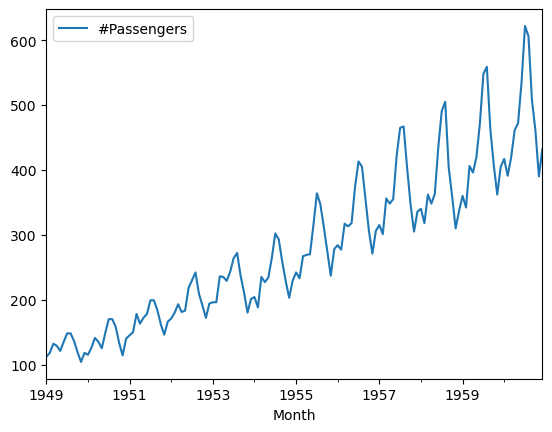

In [5]:
## PLOT THE TIME SERIES
df.plot(x='Month',y='#Passengers')
plt.show()

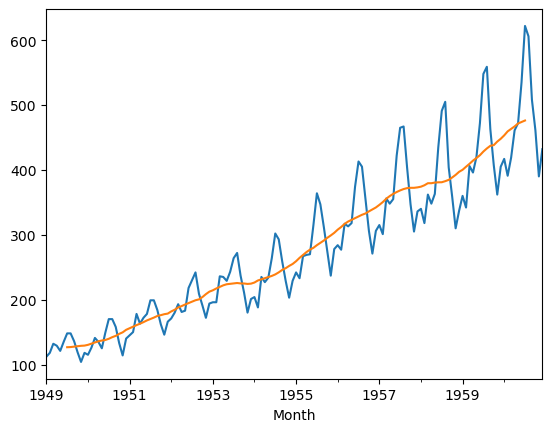

In [6]:
## USE ROLLING WINDOW TO REVEAL TREND (W=12 season length)
df0=df.copy()
df0.set_index('Month',inplace=True)
df0['#Passengers'].plot()
df0['#Passengers'].rolling(12,center=True).mean().plot()
plt.show()

# The model appears to be mutiplicative (noise/seasonal amplitude increasing in time)

## Using a regression model assuming a multiplicative model

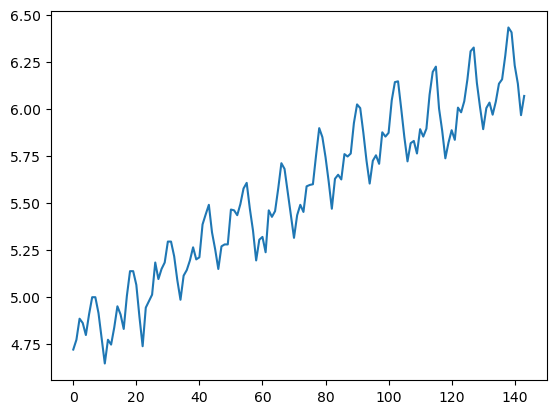

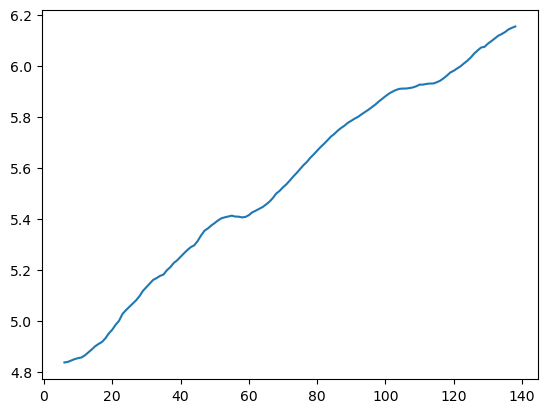

In [7]:
df['log_#Passengers']=np.log(df['#Passengers']) ## transform the multiplicative model into an additive model by taking the log
df['log_#Passengers'].plot()
plt.show()

## it seems we are left with a linear model with linear trend
df['log_#Passengers'].rolling(12,center=True).mean().plot() 
plt.show()

In [8]:
# Create dummified variables indicating the various seasons: as here we have an yearly seasonality, the seasons will be given by th various months.
# We drop the first dummy variable to avoid collinearity problems.
df['Month_no']=df['Month'].dt.month
month_vars=pd.get_dummies(df['Month_no'], drop_first=True,prefix='m').astype(int)

# concatenate the dummy columns to the original dataset and rename it df for regression: df_regr
df_regr = pd.concat([df,month_vars], axis=1)

# Add the time variable: here we consider the number of days from the first observation
df_regr['time']=df_regr['Month'].diff().dt.days.fillna(0).cumsum()

df_regr.head()

,Month,#Passengers,log_#Passengers,Month_no,m_2,m_3,m_4,m_5,m_6,m_7,m_8,m_9,m_10,m_11,m_12,time
0,1949-01-01,112,4.718499,1,0,0,0,0,0,0,0,0,0,0,0,0.0
1,1949-02-01,118,4.770685,2,1,0,0,0,0,0,0,0,0,0,0,31.0
2,1949-03-01,132,4.882802,3,0,1,0,0,0,0,0,0,0,0,0,59.0
3,1949-04-01,129,4.859812,4,0,0,1,0,0,0,0,0,0,0,0,90.0
4,1949-05-01,121,4.795791,5,0,0,0,1,0,0,0,0,0,0,0,120.0


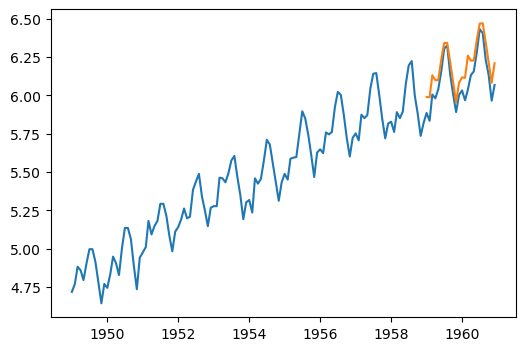

,Odds Ratio,5%,95%,t-value,p-value
const,4.716277,4.678601,4.753952,248.159278,1.521021e-149
time,0.000349,0.000340,0.000358,73.237670,2.998753e-93
m_2,-0.013634,-0.062184,0.034915,-0.556721,5.788808e-01
m_3,0.120809,0.072257,0.169361,4.932688,2.989444e-06
m_4,0.077492,0.028936,0.126048,3.163753,2.027814e-03
m_5,0.068016,0.019454,0.116578,2.776545,6.487540e-03
m_6,0.191654,0.143085,0.240224,7.822469,3.896370e-12
m_7,0.288002,0.239423,0.336580,11.752706,5.590449e-21
m_8,0.278731,0.230141,0.327320,11.371759,4.017690e-20
m_9,0.142916,0.094313,0.191518,5.829167,5.965968e-08


In [9]:
import statsmodels.api as sm
import numpy as np


# split data into training and test sets
features=['time', 'm_2', 'm_3', 'm_4', 'm_5', 'm_6', 'm_7', 'm_8', 'm_9', 'm_10', 'm_11', 'm_12']
Y_train = df_regr['log_#Passengers'].iloc[:-24]
X_train = df_regr[features].iloc[:-24]
X_train = sm.add_constant(X_train)

Y_test = df_regr['log_#Passengers'].iloc[-24:]
X_test = df_regr[features].iloc[-24:]
X_test = sm.add_constant(X_test)

# fit regression model 
model = sm.OLS(Y_train,X_train)
results = model.fit()



predictions = results.predict(X_test)
# Plot the real data points and the model predictions
plt.figure(figsize=(6, 4))
plt.plot(df['Month'], df['log_#Passengers'])
plt.plot(df['Month'].iloc[-24:], predictions)
plt.show()


conf = results.conf_int()
params=np.reshape(results.params,(results.params.size,1))
tvalues=np.reshape(results.tvalues,(results.tvalues.size,1))
pvalues=np.reshape(results.pvalues,(results.pvalues.size,1))
res_df=pd.DataFrame(np.concatenate((params,conf,tvalues,pvalues),axis=1))
res_df.columns=['Odds Ratio','5%', '95%', 't-value','p-value']
res_df.index=['const']+features
res_df


### stationarity and autocorrelation of residuals

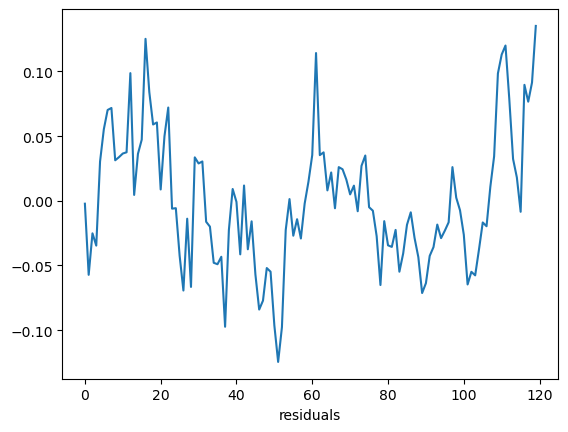

ADF Statistic:  -3.5569145534447375
P-Value:  0.006640209853923139
Critical Values:
	1%: -3.49
	5%: -2.89
	10%: -2.58

Residuals are stationary.


       lb_stat     lb_pvalue
1    66.158640  4.160520e-16
2   108.994857  2.148164e-24
3   130.124786  5.083720e-28
4   141.440215  1.387677e-29
5   153.505399  2.394363e-31
6   163.705584  9.714750e-33
7   171.493533  1.215677e-33
8   176.311626  6.121808e-34
9   179.536930  6.330126e-34
10  181.437703  1.178259e-33

Residuals show non-trivial autocorrelation!


In [10]:
plt.plot((results.predict(X_train) - Y_train))
plt.xlabel('time')
plt.xlabel('residuals')
plt.show()


### TEST STATIONARITY OF RESIDUALS
from statsmodels.tsa.stattools import adfuller

def adf_test(series):
    """Using an ADF test to determine if a series is stationary"""
    test_results = adfuller(series)
    print('ADF Statistic: ', test_results[0])
    print('P-Value: ', test_results[1])
    print('Critical Values:')
    for thres, adf_stat in test_results[4].items():
        print('\t%s: %.2f' % (thres, adf_stat))
 
adf_test((results.predict(X_train) - Y_train))
print('\nResiduals are stationary.\n\n')

from statsmodels.stats.diagnostic import acorr_ljungbox

print(acorr_ljungbox((results.predict(X_train) - Y_train), return_df=True))
print('\nResiduals show non-trivial autocorrelation!')

### Toward stationarity: Regularizing multiplicative noise/seasonality effects using log transformation

Text(0.5, 0, '')

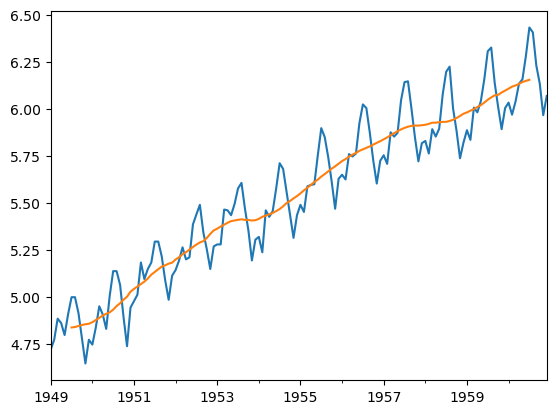

In [11]:
df.set_index('Month',inplace=True)
df['log_#Passengers']=np.log(df['#Passengers'])
df['log_#Passengers'].plot()
df['log_#Passengers'].rolling(12,center=True).mean().dropna().plot()
plt.xlabel('')

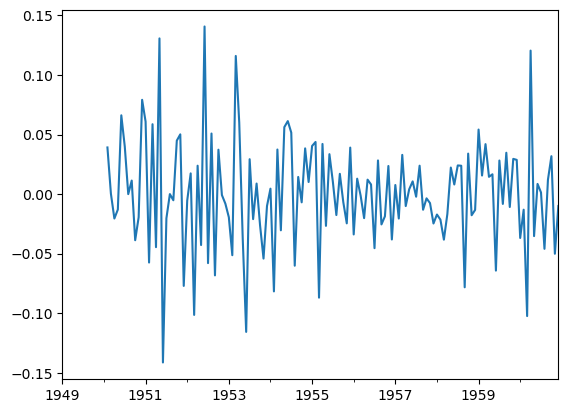

ADF Statistic:  -4.443324941831115
P-Value:  0.0002485912311384133
Critical Values:
	1%: -3.49
	5%: -2.89
	10%: -2.58


In [12]:
df['diff_diff12_log_#Passengers']=np.log(df['#Passengers']).diff(12).diff(1)
df['diff_diff12_log_#Passengers'].plot()
plt.xlabel('')
plt.show()

adf_test(df["diff_diff12_log_#Passengers"].dropna())

#### effects on autocorrelation pattern

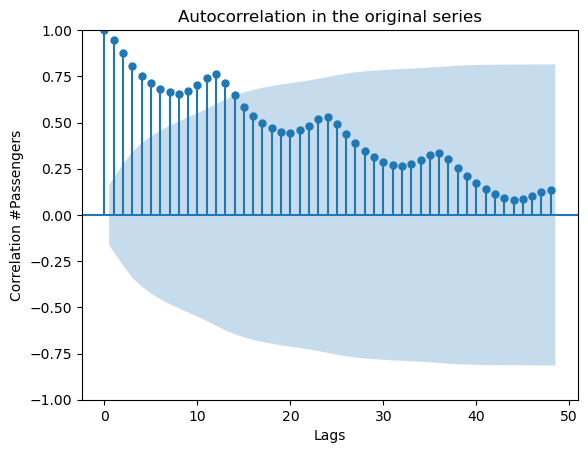

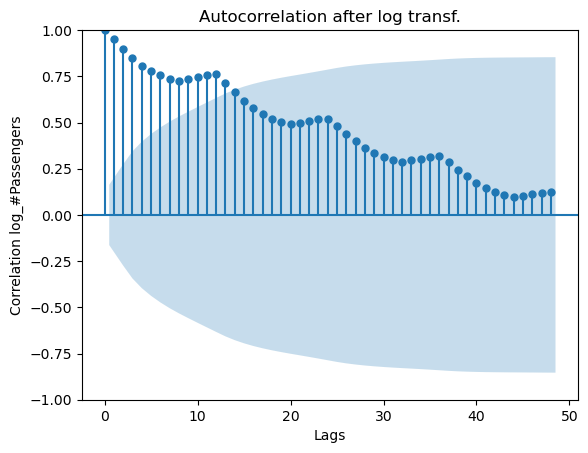

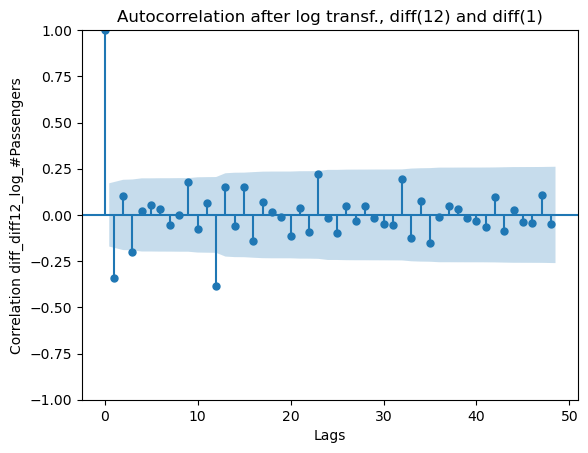

      lb_stat  lb_pvalue
1   15.595655   0.000078
2   17.086040   0.000195
3   22.647794   0.000048
4   22.710382   0.000145
5   23.138684   0.000318
6   23.270941   0.000711
7   23.704967   0.001284
8   23.705049   0.002568
9   28.147330   0.000901
10  28.986885   0.001252



In [13]:

# Import packages
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox


plot_acf(df['#Passengers'],lags=48)
plt.ylabel('Correlation #Passengers')
plt.xlabel('Lags')
plt.title('Autocorrelation in the original series')
plt.show()

plot_acf(df['log_#Passengers'].dropna(),lags=48)
plt.ylabel('Correlation log_#Passengers')
plt.xlabel('Lags')
plt.title('Autocorrelation after log transf.')
plt.show()

plot_acf(df['diff_diff12_log_#Passengers'].dropna(),lags=48)
plt.ylabel('Correlation diff_diff12_log_#Passengers')
plt.xlabel('Lags')
plt.title('Autocorrelation after log transf., diff(12) and diff(1)')
plt.show()

# Carry out Ljung-Box test to check autocorrelation leftovers
print(acorr_ljungbox(df['diff_diff12_log_#Passengers'].dropna(), return_df=True))
print()

### Regularizing multiplicative noise/seasonality effects using Box-Cox transformation

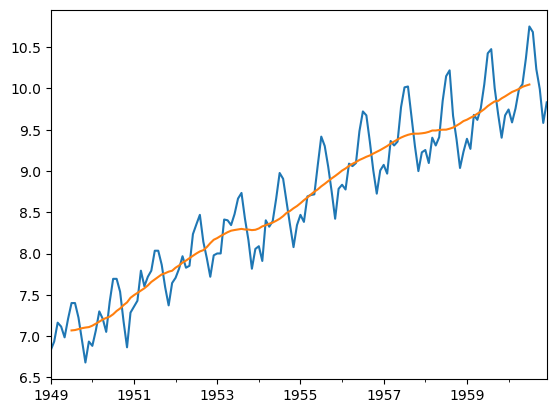

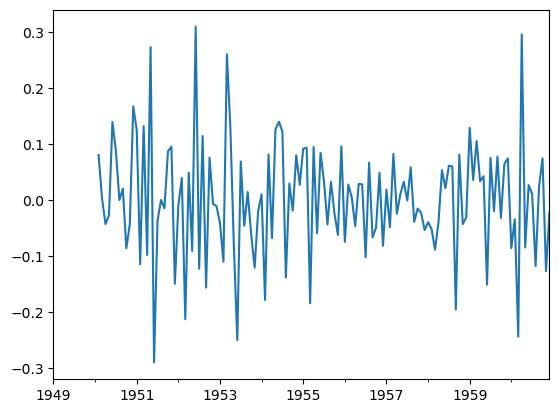

ADF Statistic:  -4.393872642589013
P-Value:  0.0003043325595875915
Critical Values:
	1%: -3.49
	5%: -2.89
	10%: -2.58


In [14]:
from scipy.stats import boxcox

transformed, lambda0 = boxcox(df['#Passengers'])
df['BoxCox_#Passengers']= transformed

df['BoxCox_#Passengers'].plot()
df['BoxCox_#Passengers'].rolling(12,center=True).mean().dropna().plot()
plt.xlabel('')
plt.show()


## remove seasonality and trend 
df['diff_diff12_BoxCox_#Passengers']=df['BoxCox_#Passengers'].diff(12).diff(1)
df['diff_diff12_BoxCox_#Passengers'].plot()
plt.xlabel('')
plt.show()


#test stationarity
adf_test(df["diff_diff12_BoxCox_#Passengers"].dropna())

## Making the series stationary using built-in methods
 If we consider an additive model, such that
 $$ y_t= L + T + S + \epsilon $$
 or a multiplicative model
 $$ y_t= L \times T \times S \times \epsilon $$
 which can be rewritten as
  $$ \log(y_t)= \log(L) + \log(T) + \log( S ) + \log(\epsilon) $$

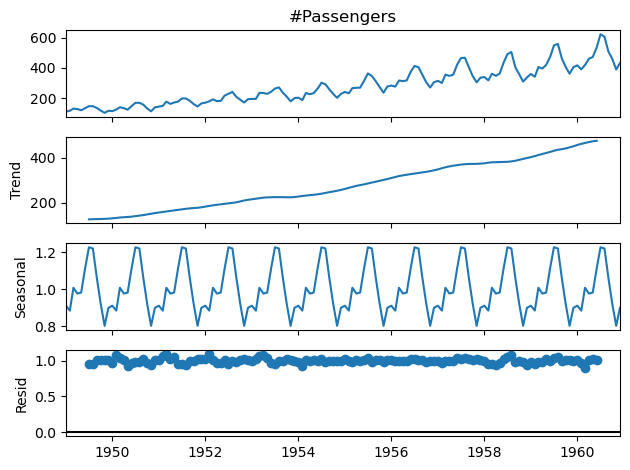

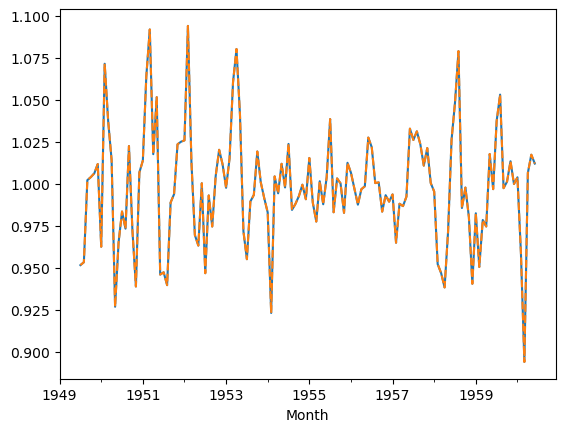

ADF Statistic:  -7.41592464088523
P-Value:  6.936028992598774e-11
Critical Values:
	1%: -3.48
	5%: -2.89
	10%: -2.58


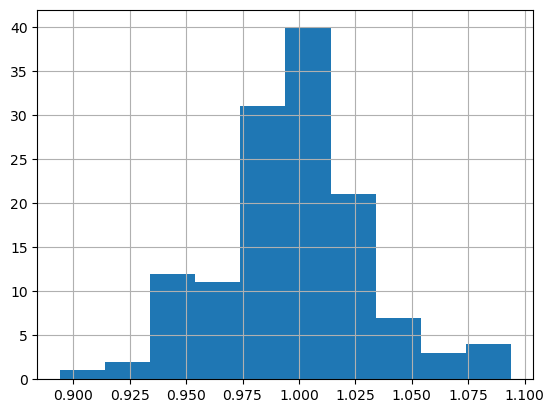

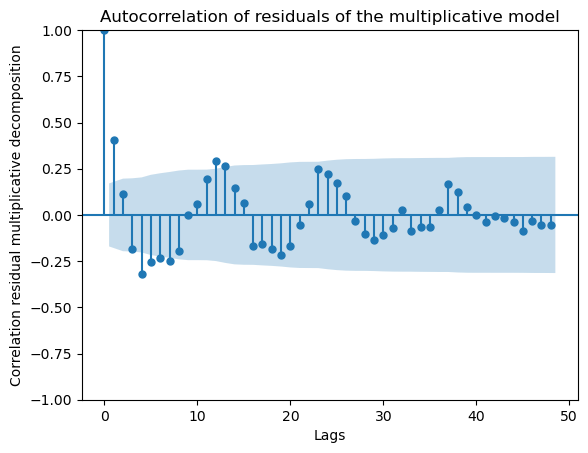


      lb_stat     lb_pvalue
1   21.970189  2.769185e-06
2   23.653136  7.307801e-06
3   28.204838  3.289659e-06
4   42.261397  1.472480e-08
5   51.152961  8.046618e-10
6   58.713506  8.212510e-11
7   67.692339  4.318005e-12
8   73.125648  1.169579e-12
9   73.125713  3.701220e-12
10  73.668843  8.634426e-12


In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose

#the model is multiplicative
df0=df.copy()
decomposition_plot_multi = seasonal_decompose(df0['#Passengers'],model='multiplicative')

# plot the various components
decomposition_plot_multi.plot()
plt.show()

#trend: decomposition_plot_multi.trend
#season: decomposition_plot_multi.seasonal
#residuals: decomposition_plot_multi.resid
## check that the model can be reconstructed using the decomposed attributes
(df0['#Passengers'] / (decomposition_plot_multi.trend * decomposition_plot_multi.seasonal)).dropna().plot(linestyle='-')
decomposition_plot_multi.resid.plot(linestyle='--')
plt.show()

adf_test(decomposition_plot_multi.resid.dropna())

decomposition_plot_multi.resid.hist(bins=10)
plt.show()


plot_acf(decomposition_plot_multi.resid.dropna(),lags=48)
plt.ylabel('Correlation residual multiplicative decomposition')
plt.xlabel('Lags')
plt.title('Autocorrelation of residuals of the multiplicative model')
plt.show()
print()

# Carry out Ljung-Box test
print(acorr_ljungbox(decomposition_plot_multi.resid.dropna(), return_df=True))



### repeat the procedure using log transformation to get an additive model

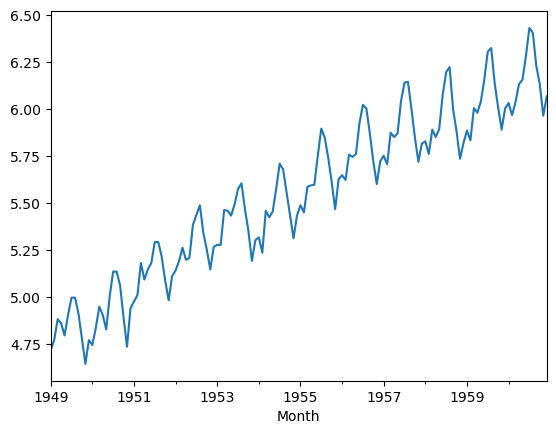

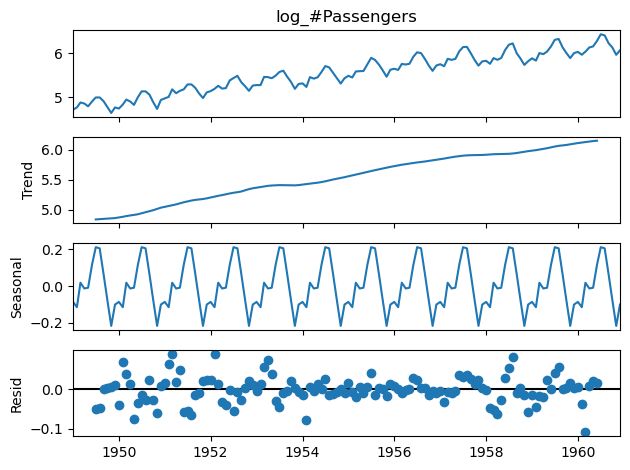

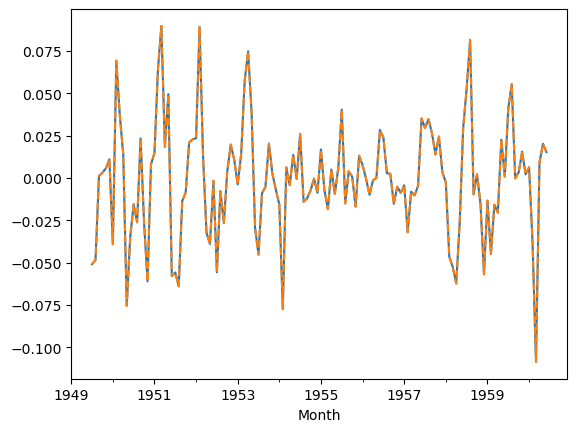

ADF Statistic:  -6.33238679764489
P-Value:  2.885058903323019e-08
Critical Values:
	1%: -3.49
	5%: -2.89
	10%: -2.58


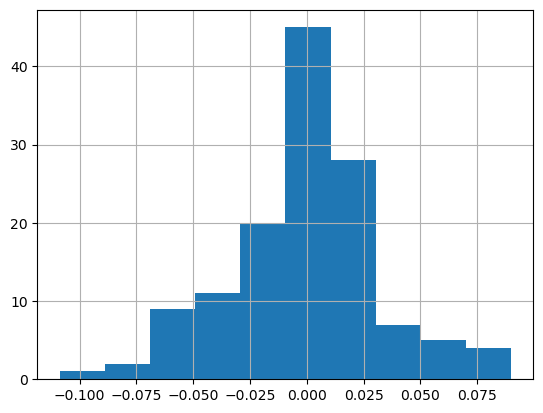

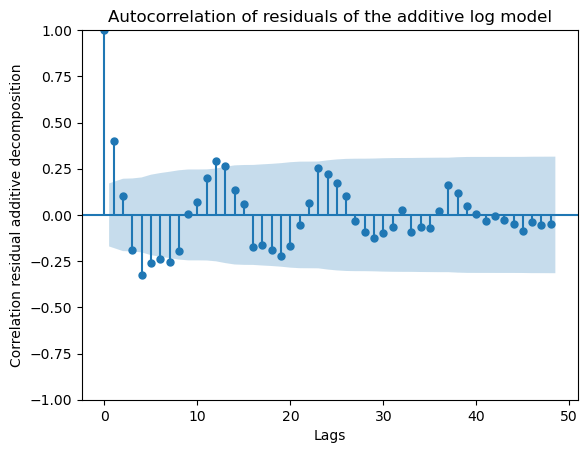


      lb_stat     lb_pvalue
1   21.475890  3.583054e-06
2   22.930211  1.048982e-05
3   27.977434  3.671864e-06
4   42.752457  1.164686e-08
5   52.214748  4.874448e-10
6   60.113002  4.269260e-11
7   69.212078  2.131420e-12
8   74.504083  6.199569e-13
9   74.507616  1.976627e-12
10  75.235287  4.281564e-12


In [16]:
#after taking the log transformation the model is additive
df0['log_#Passengers'].plot()
plt.show()

# decompose
decomposition_plot_addi = seasonal_decompose(df0['log_#Passengers'],model='additive')
decomposition_plot_addi.plot()
plt.show()


# check decomposition consistency
(df0['log_#Passengers'] - decomposition_plot_addi.trend - decomposition_plot_addi.seasonal).dropna().plot(linestyle='-')
decomposition_plot_addi.resid.plot(linestyle='--')
plt.show()

# test residuals stationarity
adf_test(decomposition_plot_addi.resid.dropna())

decomposition_plot_addi.resid.hist(bins=10)
plt.show()


plot_acf(decomposition_plot_addi.resid.dropna(),lags=48)
plt.ylabel('Correlation residual additive decomposition')
plt.xlabel('Lags')
plt.title('Autocorrelation of residuals of the additive log model')
plt.show()
print()
# Carry out Ljung-Box test
print(acorr_ljungbox(decomposition_plot_addi.resid.dropna(), return_df=True))

## Fitting an AR(p) model. Look at PACF behaviour!

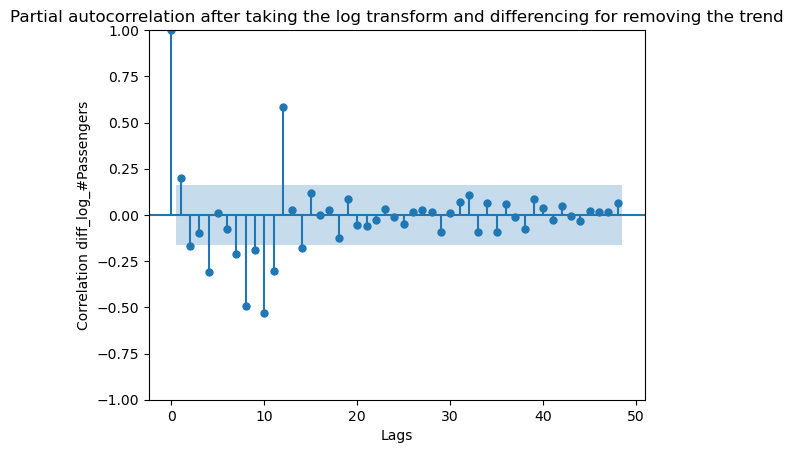

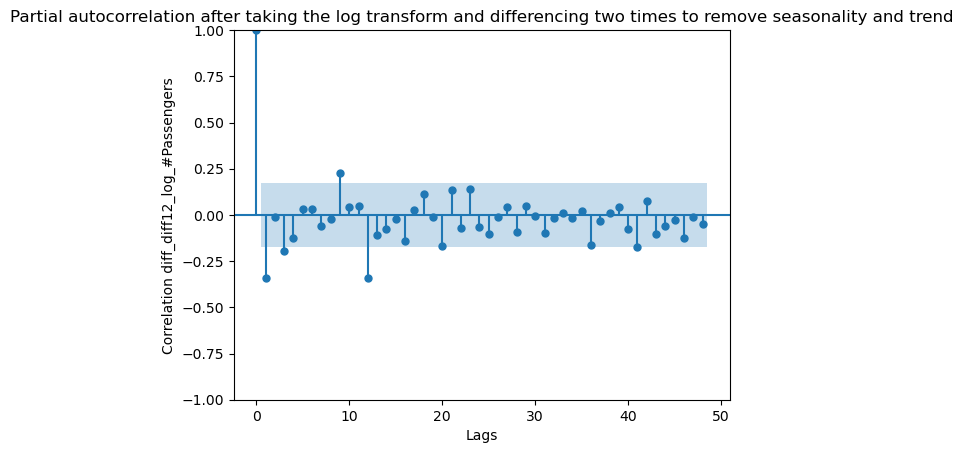

In [17]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(np.log(df['#Passengers']).diff().dropna(),lags=48)
plt.ylabel('Correlation diff_log_#Passengers')
plt.xlabel('Lags')
plt.title('Partial autocorrelation after taking the log transform and differencing for removing the trend')



plot_pacf(df['diff_diff12_log_#Passengers'].dropna(),lags=48)
plt.ylabel('Correlation diff_diff12_log_#Passengers')
plt.xlabel('Lags')
plt.title('Partial autocorrelation after taking the log transform and differencing two times to remove seasonality and trend')
plt.show()



In [60]:
# Import packages
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

df.index = pd.to_datetime(df.index)
# Set the frequency explicitly to monthly start ('MS')
df = df.asfreq('MS')


# Apply appropriate differencing for multiplicative data
# First seasonal differencing to remove seasonality, then regular differencing for trend
df['diff_seasonal'] = df['BoxCox_#Passengers'].diff(12)
df['diff_seasonal_regular'] = df['diff_seasonal'].diff()

# Split into train and test sets
train = df.iloc[:-24]
test = df.iloc[-24:]

# Find best AR order using the properly differenced series
selector = ar_select_order(train['diff_seasonal_regular'].dropna(), maxlag=12)
print(f"Selected AR lags: {selector.ar_lags}")

# Build AR model with consistent differencing approach
model = AutoReg(
    train['diff_seasonal_regular'].dropna(), 
    lags=selector.ar_lags
).fit()

# Get forecasts in the differenced domain
diff_forecasts = list(model.forecast(steps=len(test)))

# Convert forecasts back to original domain
# First, undo the regular differencing
seasonal_diff_forecasts = []
last_seasonal_diff = train['diff_seasonal'].iloc[-1]
for i, diff_forecast in enumerate(diff_forecasts):
    if i == 0:
        seasonal_forecast = diff_forecast + last_seasonal_diff
    else:
        seasonal_forecast = diff_forecast + seasonal_diff_forecasts[i-1]
    seasonal_diff_forecasts.append(seasonal_forecast)

# Then, undo the seasonal differencing
boxcox_forecasts = []
for i, seasonal_diff_forecast in enumerate(seasonal_diff_forecasts):
    if i < 12:  # Use actual values from train for the first 12 months
        idx = len(train) - 12 + i
        boxcox_forecast = seasonal_diff_forecast + train['BoxCox_#Passengers'].iloc[idx]
    else:  # Use forecasted values for subsequent months
        boxcox_forecast = seasonal_diff_forecast + boxcox_forecasts[i-12]
    boxcox_forecasts.append(boxcox_forecast)

# Finally, invert the Box-Cox transformation
forecasts = inv_boxcox(boxcox_forecasts, lambda0)

# Plot the forecasts
def plot_forecasts(forecasts, title):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=train.index, y=train['#Passengers'], name='Train'))
    fig.add_trace(go.Scatter(x=test.index, y=test['#Passengers'], name='Test'))
    fig.add_trace(go.Scatter(x=test.index, y=forecasts, name='Forecast'))
    fig.update_layout(template="simple_white", font=dict(size=18), title_text=title,
                      width=650, title_x=0.5, height=400, xaxis_title='Date',
                      yaxis_title='Passenger Volume')
    return fig.show()

plot_forecasts(forecasts, 'Autoregression Forecast')

mean_abs_err=(np.abs(forecasts-test['#Passengers'])/test['#Passengers']).mean()
print(f'Mean absolute error: {mean_abs_err}')

Selected AR lags: [1]


Mean absolute error: 0.15270668196698592


### version 2: circumventing seasonality reconstruction

In [61]:

# Find best AR order using the twice-differenced series
selector = ar_select_order(train['diff_seasonal_regular'].dropna(), maxlag=12)
print(f"Selected AR lags: {selector.ar_lags}")

# Build AR model on seasonally differenced data with seasonal dummies
model = AutoReg(
    train['diff_seasonal'].dropna(), 
    lags=selector.ar_lags,
    seasonal=True,  # Use seasonal dummies
    period=12       # Monthly data
).fit()

# Generate forecasts
diff_forecasts = model.forecast(steps=len(test))

# Undo the seasonal differencing directly (simpler than before)
boxcox_forecasts = []
for i, diff_forecast in enumerate(diff_forecasts):
    if i < 12:  # Use actual values for first 12 steps
        idx = len(train) - 12 + i
        boxcox_forecast = diff_forecast + train['BoxCox_#Passengers'].iloc[idx]
    else:  # Use forecasted values for subsequent steps
        boxcox_forecast = diff_forecast + boxcox_forecasts[i-12]
    boxcox_forecasts.append(boxcox_forecast)

# Finally, invert the Box-Cox transformation
forecasts = inv_boxcox(boxcox_forecasts, lambda0)


# Plot the forecasts
def plot_forecasts(forecasts, title):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=train.index, y=train['#Passengers'], name='Train'))
    fig.add_trace(go.Scatter(x=test.index, y=test['#Passengers'], name='Test'))
    fig.add_trace(go.Scatter(x=test.index, y=forecasts, name='Forecast'))
    fig.update_layout(template="simple_white", font=dict(size=18), title_text=title,
                      width=650, title_x=0.5, height=400, xaxis_title='Date',
                      yaxis_title='Passenger Volume')
    return fig.show()

plot_forecasts(forecasts, 'Autoregression Forecast v2')

mean_abs_err=(np.abs(forecasts-test['#Passengers'])/test['#Passengers']).mean()
print(f'Mean absolute error: {mean_abs_err}')

Selected AR lags: [1]


Mean absolute error: 0.037762819533529446


## ARIMA MODEL ON THE LINEARIZED ORIGINAL MODEL

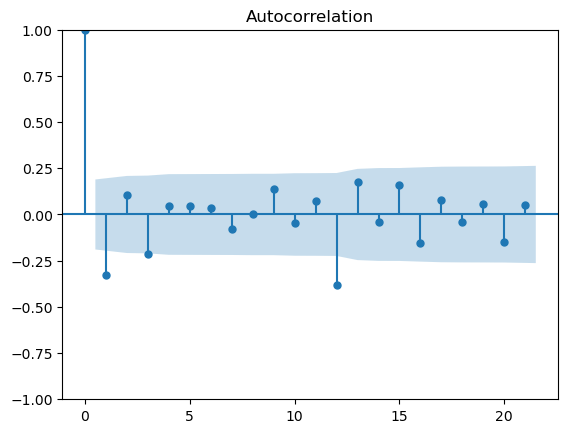

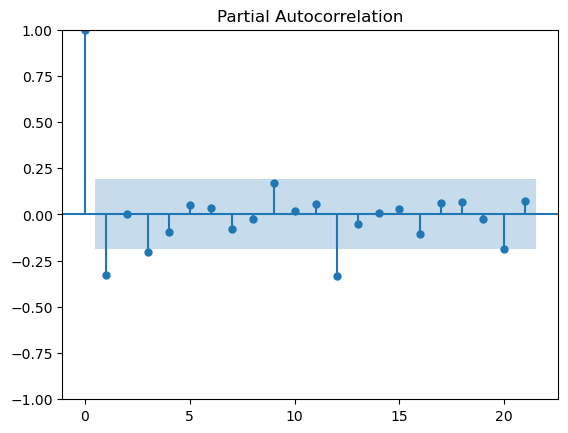

In [62]:
plot_acf(train['diff_seasonal_regular'].dropna())
plt.show()

plot_pacf(train['diff_seasonal_regular'].dropna())
plt.show()

In [63]:
from statsmodels.tsa.arima.model import ARIMA
# Build ARIMA model
# order=(p,d,q) where:
# p: AR order, d: differencing, q: MA order
model = ARIMA(
    train['BoxCox_#Passengers'],  # Using the Box-Cox transformed data
    order=(1, 1, 1),              # ARIMA(1,1,1)
    seasonal_order=(1, 1, 1, 12)  # Seasonal ARIMA component (P,D,Q,s)
).fit()

# Generate forecasts directly in the Box-Cox space
boxcox_forecasts = model.forecast(steps=len(test))

# Invert the Box-Cox transformation to get back to the original scale
forecasts = inv_boxcox(boxcox_forecasts, lambda0)

# Plot the forecasts
def plot_forecasts(forecasts, title):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=train.index, y=train['#Passengers'], name='Train'))
    fig.add_trace(go.Scatter(x=test.index, y=test['#Passengers'], name='Test'))
    fig.add_trace(go.Scatter(x=test.index, y=forecasts, name='Forecast'))
    fig.update_layout(template="simple_white", font=dict(size=18), title_text=title,
                      width=650, title_x=0.5, height=400, xaxis_title='Date',
                      yaxis_title='Passenger Volume')
    return fig.show()

plot_forecasts(forecasts, 'ARIMA Forecast')


mean_abs_err=(np.abs(forecasts-test['#Passengers'])/test['#Passengers']).mean()
print(f'Mean absolute error: {mean_abs_err}')

Mean absolute error: 0.10054154216544058
